# Initialize

In [1]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

from scipy.stats import wilcoxon, mannwhitneyu
import os

from nems0 import db
import nems0.epoch as ep
import nems0.plots.api as nplt
from nems0.utils import smooth
from nems_lbhb.xform_wrappers import generate_recording_uri
from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems_lbhb.plots import plot_waveforms_64D
from nems_lbhb.preprocessing import impute_multi
from nems_lbhb import baphy_io
from nems_lbhb.projects.freemoving.free_tools import compute_d_theta, free_scatter_sum, dlc2dist
from nems_lbhb.projects.freemoving import free_model, free_vs_fixed_strfs
from nems.tools import json
from nems_lbhb.baphy_io import load_continuous_openephys, get_spike_info, get_depth_info

In [2]:
# very inefficiant function to rotate in the xy-plane
def rotate_via_numpy(xy, radians):
    """Use numpy to build a rotation matrix and take the dot product."""
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, xy)

    return m

# euclidean distance
def ptdist(x,y):
    return np.sqrt(np.mean((x-y)**2))

DLC head marker coordinates of [front, backpost, right tether, left tether]. These are in mm, units don't really matter.

In [20]:
# (x,y,z) x 4
# SLJ - 2 chimneys
xyz=np.array([[ 0,    0,  51.9, -53,],
              [-36.4, 0, -6.1,  -5.4],
              [-14,   0,  13.1, 11.3]])
animal="SLJ"


# LMD
xyz=np.array([[0, 0, 52, -52],
              [-34, 0, -2.3, -2.3],
              [-17.25, 0, 18.75, 18.75]])
animal="LMD"

# PRN right chimney
xyz=np.array([[ 0,    0, -53,  25],
              [-36.4, 0,  -5.4, -3],
              [-14,   0, 11.3,  -23]])
# PRN left chimney
xyz=np.array([[ 0,    0,  25, -53],
              [-36.4, 0, -3,  -5.4],
              [-14,   0,  -23, 11.3]])
animal="PRN"



## Generate tilt,yaw lookup table 
Simulate effect of tilt and yaw on 2d projection of head coordinates. Currently 10 deg steps. Should probably be higher res. But probably want to skip plotting in that case.

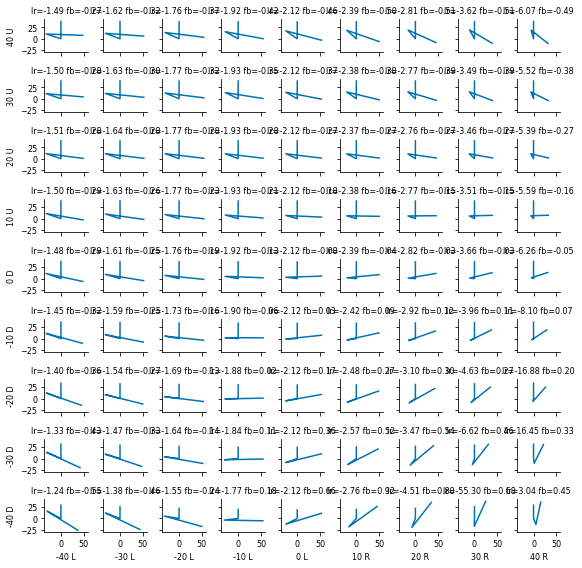

In [21]:
tilts=np.arange(40,-50,-10)/180*np.pi
yaws=np.arange(-40,50,10)/180*np.pi
N=len(tilts)

f,ax=plt.subplots(N,N, sharex=True, sharey=True, figsize=(8,8))

lr=np.zeros((N,N))
fb=np.zeros((N,N))
tt=np.zeros((N,N))
yy=np.zeros((N,N))

for i, tilt in enumerate(tilts):
    for j, yaw in enumerate(yaws):
        X=xyz.copy()
        X[1:,:] = rotate_via_numpy(X[1:,:],tilt)
        X[0::2,:] = rotate_via_numpy(X[0::2,:],yaw)
        #ax[i,j].plot(X[0,:], X[1,:])
        
        x= X[0,:]
        y= X[1,:]
        delta=[x[1]-x[0], y[1]-y[0]]
        angle=np.arctan(delta[0]/delta[1])
        if y[0]>y[1]:
            xy = rotate_via_numpy(np.stack((x,y),axis=1).T,-angle)
        else:
            xy = rotate_via_numpy(np.stack((x,y),axis=1).T,np.pi-angle)
        xy-=xy[:,[1]]

        ax[i,j].plot(xy[0,:].T,xy[1,:].T)
        lr[i,j]=(xy[0,3]-xy[0,1]) / (xy[0,2]-xy[0,1])
        fb[i,j]=(xy[1,1]-(xy[1,2]+xy[1,2])/2) / (xy[1,0]-xy[1,1])
        tt[i,j]=tilt/np.pi*180
        yy[i,j]=yaw/np.pi*180
        ax[i,j].set_title(f"lr={lr[i,j]:.2f} fb={fb[i,j]:.2f}")
        if i==N-1:
            if yaw>0:
                ax[i,j].set_xlabel(f"{yaw/np.pi*180:0.0f} R")
            else:
                ax[i,j].set_xlabel(f"{yaw/np.pi*180:0.0f} L")
    if tilt>0:
        ax[i,0].set_ylabel(f"{tilt/np.pi*180:0.0f} U")
    else:
        ax[i,0].set_ylabel(f"{tilt/np.pi*180:0.0f} D")

#yl=ax[0,0].get_ylim()
#ax[0,0].set_ylim([yl[1],yl[0]])
plt.tight_layout()

tilts=tt.flatten()
yaws=yy.flatten()
lr=lr.flatten()
fb=fb.flatten()

## Load some data

In [5]:
if animal=="LMD":
    dlc_file = '/auto/data/daq/LemonDisco/LMD004/sorted/LMD004a07_a_NFB.dlc.h5'
    video_file = '/auto/data/daq/LemonDisco/LMD004/LMD004a07_a_NFB.avi'
elif animal=="PRN":
    dlc_file = '/auto/data/daq/Prince/PRN048/sorted/PRN048a02_a_NTDDLC_resnet50_free_top_RHFeb17shuffle1_100000.h5'
    video_file = '/auto/data/daq/Prince/PRN048/PRN048a02_a_NTD.avi'
elif animal=="SLJ":
    dlc_file = '/auto/data/daq/SlipperyJack/SLJ019/sorted/SLJ019a05_a_NTD.dlc.h5'
    video_file = '/auto/data/daq/SlipperyJack/SLJ019/SLJ019a05_a_NTD.avi'
else:
    raise ValueError(f"unknown animal {animal}")
dlc, bodyparts = baphy_io.load_dlc_trace(dlc_file, return_raw=True)
print(dlc.shape)

(14, 41266)


# Compute rotations

Find nearest-neighbor (tilt,yaw) for each frame

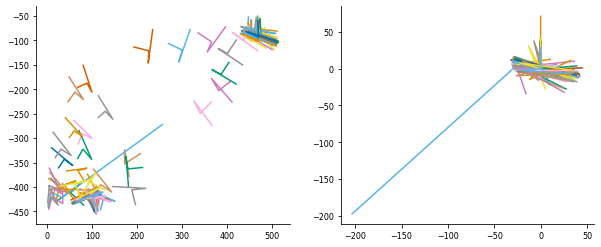

In [24]:
f,ax=plt.subplots(1,2,figsize=(10,4))
ty=np.zeros((2,dlc.shape[1]))

for i in range(0,10000,100):
    d = dlc[:,i]
    x=d[0:8:2]
    y=-d[1:8:2]
    ax[0].plot(x,y)
    
    delta=[x[1]-x[0], y[1]-y[0]]
    angle=np.arctan(delta[0]/delta[1])
    if y[0]>y[1]:
        xy = rotate_via_numpy(np.stack((x,y),axis=1).T,-angle)
    else:
        xy = rotate_via_numpy(np.stack((x,y),axis=1).T,np.pi-angle)
    xy-=xy[:,[1]]
    
    ax[1].plot(xy[0,:].T,xy[1,:].T)
    
    lr1=(xy[0,3]-xy[0,1]) / (xy[0,2]-xy[0,1])
    fb1=(xy[1,1]-(xy[1,2]+xy[1,2])/2) / (xy[1,0]-xy[1,1])
    aa = np.argmin((lr-lr1)**2+(fb-fb1)**2)
    ty[:,i]=np.array([tilts[aa],yaws[aa]])


In [32]:
i=200
d = dlc[:,i]
x=d[0:8:2]
y=-d[1:8:2]
ax[0].plot(x,y)

delta=[x[1]-x[0], y[1]-y[0]]
angle=np.arctan(delta[0]/delta[1])
if y[0]>y[1]:
    xy = rotate_via_numpy(np.stack((x,y),axis=1).T,-angle)
else:
    xy = rotate_via_numpy(np.stack((x,y),axis=1).T,np.pi-angle)
xy-=xy[:,[1]]

lr1=(xy[0,3]-xy[0,1]) / (xy[0,2]-xy[0,1])
fb1=(xy[1,1]-(xy[1,2]+xy[1,2])/2) / (xy[1,0]-xy[1,1])
aa = np.argmin((lr-lr1)**2+(fb-fb1)**2)
aa,np.array([tilts[aa],yaws[aa]])

(63, array([-30., -40.]))

In [31]:
lr.shape, fb.shape

((81,), (81,))

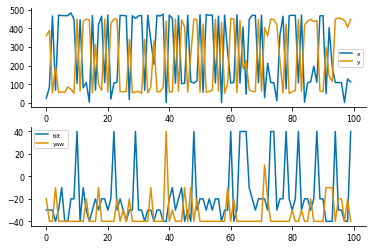

In [25]:
f,ax=plt.subplots(2,1)
ax[0].plot(dlc[0:2,:10000:100].T)
ax[0].legend(('x','y'))
ax[1].plot(ty[:,:10000:100].T)
ax[1].legend(('tilt','yaw'))

# Demo plots

Extract a bunch of frames into /tmp/. Slow.

In [26]:
t = 1
for t in range(100,10000,100):
    #cmd = f"ffmpeg -i {video_file} -ss {t/30} -vframes 1 /tmp/frame{t:05d}.jpg"
    cmd = f"ffmpeg -i {video_file} -vf select='eq(n\,{t})' -vsync 0 /auto/data/tmp/{animal}/frame{t:05d}.jpg"
    os.system(cmd)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Function to plot the geometry extracted from one frame.

In [27]:
def plot_frame(t):
    # load image as pixel array
    im = image.imread(f'/auto/data/tmp/{animal}/frame{t:05d}.jpg')
    plt.figure(figsize=(10,8))
    plt.imshow(im)
    d = dlc[:,t]
    x=d[0:8:2]
    y=d[1:8:2]

    x0, y0, z0 = 320, 240, 975
    cameraoffset=np.array([320-x[1],240-y[1]])

    delta=np.array([x[0]-x[1], y[0]-y[1]])
    proj = np.dot(cameraoffset, delta)/(delta[0]**2+delta[1]**2) * delta + np.array([x[1],y[1]])

    plt.plot(x,y,lw=3)
    plt.plot([320,x[1]],[240,y[1]])
    plt.plot([320,proj[0]], [240, proj[1]])
    sideoffset=((proj[0]-x0)**2 + (proj[1]-y0)**2)**0.5
    fwdoffset=((proj[0]-x[1])**2 + (proj[1]-y[1])**2)**0.5
    if ptdist(np.array([x0,y0]),np.array([x[2],y[2]])) < ptdist(np.array([x0,y0]),np.array([x[3],y[3]])):
        sideoffset=-sideoffset
    if ptdist(proj,np.array([x[1],y[1]])) > ptdist(proj,np.array([x[0],y[0]])):
        fwdoffset=-fwdoffset
    fwangle=np.arctan(fwdoffset/z0)*180/np.pi
    sdangle=np.arctan(sideoffset/z0)*180/np.pi

    if ty[0,t]>0:
        ts=f"{ty[0,t]} U"
    else:
        ts=f"{ty[0,t]} D"
    if ty[1,t]>0:
        ys=f"{ty[1,t]} R"
    else:
        ys=f"{ty[1,t]} L"

    plt.title(f"t={t} tilt: {ts}, yaw: {ys} fw: {fwangle:.0f} sd: {sdangle:.0f}" );

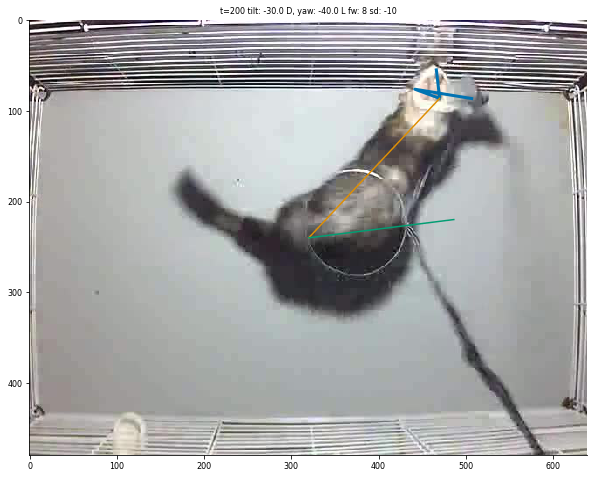

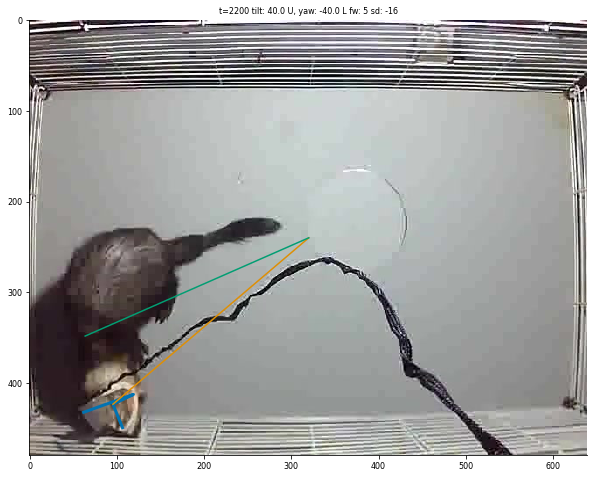

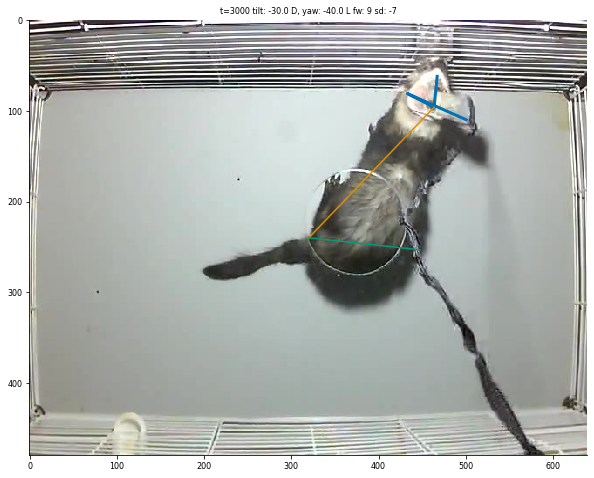

In [28]:
plot_frame(200);
plot_frame(2200);
plot_frame(3000)

In [213]:
delta=np.array([x[0]-x[1], y[0]-y[1]])
proj = np.dot(cameraoffset, delta)/(delta[0]**2+delta[1]**2)**0.5 * delta
headangle=np.arctan(delta[0]/delta[1]) * 180/np.pi
posangle=np.arctan(cameraoffset[0]/cameraoffset[1]) *180/np.pi
x[:2], y[:2], cameraoffset, delta, proj

(array([304.60958862, 316.85464478]),
 array([41.14738846, 68.82757568]),
 array([  3.14535522, 171.17242432]),
 array([-12.24505615, -27.68018723]),
 array([1932.41365563, 4368.25859507]))